## Install the environment first(take some time if you do it first time)

```bash
## only first time, including submodules
git clone --recursive git@github.com:cms-btv-pog/BTVNanoCommissioning.git 
## install conda 
wget https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
# Run and follow instructions on screen
bash Miniconda3-latest-Linux-x86_64.sh
## create environment via yaml
conda env create -f test_env.yml 
## activate the enviroment
conda activate btv_coffea
## install BTV packages
pip install -e .
```

##  Introduction for coffea- Columnar Object Framework For Effective Analysis

**Caveat: this tutorial is still based on coffea 0.7.21 version with awkward-v1, dask-awkward will not cover**

Take No.1 &4  from coffea team :  https://github.com/CoffeaTeam/coffea-hats, still useful to go over all of them to fully build up new workflow. 


[coffea](https://coffeateam.github.io/coffea/) is a prototype package for pulling together all the typical needs of a high-energy collider physics (HEP) experiment analysis using the scientific python ecosystem. 

It makes use of [uproot](https://uproot.readthedocs.io/en/latest/index.html) and [awkward-array](https://awkward-array.org/doc/main/user-guide/index.html) to provide an array-based syntax for manipulating HEP event data in an efficient and numpythonic way. 

Useful submodules implement
    
- histogramming : [hist](https://hist.readthedocs.io/)

- plotting : [mplhep](https://mplhep.readthedocs.io/en/latest/)

- [corrections](https://coffeateam.github.io/coffea/notebooks/applying_corrections.html#): [correctionlib](https://cms-nanoaod.github.io/correctionlib/correctionlib_tutorial.html), [lookup_tools](https://coffeateam.github.io/coffea/api/coffea.lookup_tools.extractor.html#coffea.lookup_tools.extractor)(in `coffea`), high level tools([JetMET tools](https://coffeateam.github.io/coffea/modules/coffea.jetmet_tools.html),[btag SFs](https://coffeateam.github.io/coffea/modules/coffea.btag_tools.html))

### Read data with coffea (NanoAOD/PFNano) 

**Get some contents from https://github.com/CoffeaTeam/coffea-hats/blob/master/01-nanoevents.ipynb**

NanoEvents is a Coffea utility to wrap flat nTuple structures into a single awkward array with appropriate object methods (such as Lorentz vector methods), cross references, and nested objects, all lazily accessed from the source ROOT TTree via uproot. The interpretation of the TTree data is configurable via [schema objects](https://coffeateam.github.io/coffea/modules/coffea.nanoevents.html#classes)(`NanoAODSchema` and `PFNanoAODSchema` included).  These schema objects allow a richer interpretation of the file contents than the [uproot.lazy](https://uproot4.readthedocs.io/en/latest/uproot4.behaviors.TBranch.lazy.html) methods. 

----------------

We will walk through quickly on some features for `coffea` with small PFNano file 

In [10]:
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, PFNanoAODSchema

fname = "root://eoscms.cern.ch//eos/cms/store/group/phys_btag/nano-commissioning/UL17_TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8_skimmed.root"
events = NanoEventsFactory.from_root(
    fname,
    schemaclass=PFNanoAODSchema,
    metadata={"dataset": "ttbar"},
).events()

/nfs/dust/cms/user/milee/miniconda3/envs/btv_coffea/lib/python3.10/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch FatJet_btagDDBvLV2 in <TTree 'Events' (2438 branches) at 0x7f79a5cbe8f0>, taking first instance
  warnings.warn(
/nfs/dust/cms/user/milee/miniconda3/envs/btv_coffea/lib/python3.10/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch FatJet_btagDDCvBV2 in <TTree 'Events' (2438 branches) at 0x7f79a5cbe8f0>, taking first instance
  warnings.warn(
/nfs/dust/cms/user/milee/miniconda3/envs/btv_coffea/lib/python3.10/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch FatJet_btagDDCvLV2 in <TTree 'Events' (2438 branches) at 0x7f79a5cbe8f0>, taking first instance
  warnings.warn(
/nfs/dust/cms/user/milee/miniconda3/envs/btv_coffea/lib/python3.10/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch Jet_btagDeepFlavC in <TTree 'Even

KeyboardInterrupt: 

In the factory constructor, we also pass the desired schema version (the latest version of NanoAOD can be built with `schemaclass=PFNanoAODSchema`) for this file and some extra metadata that we can later access with `events.metadata`. 

The `events` object is an awkward array, which at its top level is a record array with one record for each "collection", where a collection is a grouping of fields (TBranches) based on the naming conventions of [PFNanoAODSchema](https://coffeateam.github.io/coffea/api/coffea.nanoevents.PFNanoAODSchema.html#coffea.nanoevents.PFNanoAODSchema). 

For example, in the file we opened, the branches:
```
Jet_pt
Jet_eta
Jet_phi
Jet_btagDeepFlavCvL
Jet_DeepCSV_trackDeltaR_0
...
```
are grouped into one sub-record named `Jet` which can be accessed using either getitem or getattr syntax, i.e. `events["Jet"]` or `events.Jet`. 

In [2]:
events.Jet.pt, ak.type(events.Jet.pt)

(<Array [[92.8, 36, 25.1, ... 28.4, 21.4, 20.3]] type='1000 * var * float32[param...'>,
 1000 * var * float32[parameters={"__doc__": "pt"}])

The `ak.type(arrays)` will give you the [behavior](https://awkward-array.org/doc/main/reference/generated/ak.type.html?highlight=ak%20type#ak.type) of awkward array. 

Be aware of the axis of nested arrays when doing the operations. As the example given below, first one sum up the jet pT for single events while the later sum over all events

In [3]:
ak.sum(events.Jet.pt, axis=-1), ak.sum(events.Jet.pt)

(<Array [169, 464, 383, 910, ... 228, 233, 756] type='1000 * float32'>,
 353466.28)

Based on a collection's name or contents, some collections acquire additional _methods_, which are extra features exposed by the code in the mixin classes of the `coffea.nanoevents.methods` modules. Where you can access some features like TLorentzVector.

In [4]:
# list the nested branches for the Jet
events.Jet.fields

['area',
 'btagCMVA',
 'btagCSVV2',
 'btagDeepB',
 'btagDeepC',
 'btagDeepCvB',
 'btagDeepCvL',
 'btagDeepFlavB',
 'btagDeepFlavC',
 'btagDeepFlavCvB',
 'btagDeepFlavCvL',
 'btagDeepFlavQG',
 'chEmEF',
 'chFPV0EF',
 'chFPV1EF',
 'chFPV2EF',
 'chFPV3EF',
 'chHEF',
 'eta',
 'hfsigmaEtaEta',
 'hfsigmaPhiPhi',
 'mass',
 'muEF',
 'muonSubtrFactor',
 'neEmEF',
 'neHEF',
 'phi',
 'pt',
 'puIdDisc',
 'qgl',
 'rawFactor',
 'bRegCorr',
 'bRegRes',
 'cRegCorr',
 'cRegRes',
 'electronIdx1',
 'electronIdx2',
 'hfadjacentEtaStripsSize',
 'hfcentralEtaStripSize',
 'jetId',
 'muonIdx1',
 'muonIdx2',
 'nConstituents',
 'nElectrons',
 'nMuons',
 'puId',
 'DeepJet_Cpfcan_puppiw_0',
 'DeepJet_Cpfcan_drminsv_0',
 'DeepJet_Cpfcan_ptrel_0',
 'DeepJet_Cpfcan_chi2_0',
 'DeepJet_Cpfcan_BtagPf_trackDeltaR_0',
 'DeepJet_Cpfcan_BtagPf_trackEtaRel_0',
 'DeepJet_Cpfcan_BtagPf_trackJetDistVal_0',
 'DeepJet_Cpfcan_BtagPf_trackPPar_0',
 'DeepJet_Cpfcan_BtagPf_trackPParRatio_0',
 'DeepJet_Cpfcan_BtagPf_trackPtRel_0',
 '

Even though `energy` is not presented in the fields. We still can access

In [5]:
events.Jet.energy

<Array [[1.92e+03, 57.8, ... 1.11e+03, 64.8]] type='1000 * var * float32'>

And TLorentzVector operation

In [6]:
events.Jet[:, 0].delta_r(events.Muon)

<Array [[], [], [], ... [2.15], [0.0805]] type='1000 * var * float32'>

In [7]:
# a convenience method for this operation on all jets is available
events.Jet.nearest(events.Electron)

<ElectronArray [[None, None, ... Electron, Electron]] type='1000 * var * ?electron'>

In [8]:
# construct dijet mass
dijet = events.Jet[:, 0] + events.Jet[:, 1]
dijet.mass

<Array [625, 339, 96.8, ... 98.3, 155, 186] type='1000 * float32'>

Another feature is cross references. For example if we want to find the soft muon associate with the jet

In [9]:
at_least_one_muon = ak.num(events.Muon) > 0
events[at_least_one_muon].Muon[events[at_least_one_muon].Jet.muonIdx1].pt

<Array [[82.2, 82.2, 82.2, ... 4.04, 4.04]] type='727 * var * float32[parameters...'>

One can assign new variables to the arrays, with some caveats:

 * Assignment must use setitem (`events["path", "to", "name"] = value`)
 * Assignment to a sliced `events` won't be accessible from the original variable
 * New variables are not visible from cross-references

In [10]:
events["Jet", "correctpt"] = events.Jet.pt * 1.1
events.Jet.pt, events.Jet.correctpt

(<Array [[92.8, 36, 25.1, ... 28.4, 21.4, 20.3]] type='1000 * var * float32[param...'>,
 <Array [[102, 39.6, 27.7, ... 23.5, 22.3]] type='1000 * var * float32'>)

### Coffea processor

 Use the `ttbar_validation.py` from the [commissioning](https://github.com/cms-btv-pog/BTVNanoCommissioning/blob/master/src/BTVNanoCommissioning/workflows/ttbar_validation.py) framework to start up and get some [description](https://coffeateam.github.io/coffea/notebooks/processor.html) from coffea team.

As a usual analysis will involve processing tens to thousands of files, totalling gigabytes to terabytes of data, there is a certain amount of work to be done to build a parallelized framework to process the data in a reasonable amount of time. Of course, one can work directly within uproot to achieve this, as we'll show in the beginning, but coffea provides the `coffea.processor` module, which allows users to worry just about the actual analysis code and not about how to implement efficient parallelization, assuming that the parallization is a trivial map-reduce operation (e.g. filling histograms and adding them together). The module provides the following key features:

 * A `ProcessorABC` abstract base class that can be derived from to implement the analysis code;
 * A [NanoEvents](https://coffeateam.github.io/coffea/notebooks/nanoevents.html) interface to the arrays being read from the TTree as inputs;
 * A generic `accumulate()` utility to reduce the outputs to a single result, as showin in the accumulators notebook tutorial; and
 * A set of parallel **executors** to access multicore processing or distributed computing systems such as [Dask](https://distributed.dask.org/en/latest/), [Parsl](http://parsl-project.org/), [Spark](https://spark.apache.org/), [WorkQueue](https://cctools.readthedocs.io/en/latest/work_queue/), and others.  **dask @ lxplus** and **dask/parsl @ naf-desy** have been tested in BTV framework.



In [16]:
import numpy as np, awkward as ak

from coffea import processor
from coffea.analysis_tools import Weights

import hist

# not use the BTV modules at the moment
# from BTVNanoCommissioning.helpers.func import flatten
# from BTVNanoCommissioning.utils.correction import load_lumi

# from BTVNanoCommissioning.utils.histogrammer import histogrammer
# from BTVNanoCommissioning.utils.selection import jet_id
# from BTVNanoCommissioning.helpers.update_branch import missing_branch


class NanoProcessor(processor.ProcessorABC):
    def __init__(self, year="2017", campaign="Rereco17_94X"):
        self._year = year
        self._campaign = campaign
        self._year = year
        # Define histograms with hist class- https://hist.readthedocs.io/

    @property
    ## accumulating processed results
    def accumulator(self):
        return self._accumulator

    ## Place to process the Nanoevents, selections, weights, fill histogram is done here, considered as a loop with operating on columnar dataset
    def process(self, events):
        ## create the dictionary contains the
        output = {
            "sumw": processor.defaultdict_accumulator(float),
            "electron_pt": hist.Hist(
                hist.axis.Regular(50, 0, 150, name="pt", label="$p_T$ [GeV]"),
                hist.storage.Weight(),
            ),
            "muon_pt": hist.Hist(
                hist.axis.Regular(50, 0, 150, name="pt", label="$p_T$ [GeV]"),
                hist.storage.Weight(),
            ),
            ## more than one dimension is possible
            "jet_pt": hist.Hist(
                hist.axis.IntCategory([0, 1, 4, 5, 6], name="flav", label="Genflavour"),
                hist.axis.Regular(50, 0, 300, name="pt", label="$p_T$ [GeV]"),
                hist.storage.Weight(),
            ),
            "dr_mujet0": hist.Hist(
                hist.axis.IntCategory([0, 1, 4, 5, 6], name="flav", label="Genflavour"),
                hist.axis.Regular(
                    50, 0, 5, name="dr", label="$\\Delta_R(j1,\\mu)$ [GeV]"
                ),
                hist.storage.Weight(),
            ),
        }
        isRealData = not hasattr(events, "genWeight")
        dataset = events.metadata["dataset"]
        if isRealData:
            output["sumw"] = len(events)
        else:
            output["sumw"] = ak.sum(events.genWeight)

        ####################
        #    Selections    #
        ####################

        ## HLT
        triggers = [
            "Mu12_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ",
            "Mu23_TrkIsoVVL_Ele12_CaloIdL_TrackIdL_IsoVL_DZ",
        ]
        checkHLT = ak.Array([hasattr(events.HLT, _trig) for _trig in triggers])
        if ak.all(checkHLT == False):
            raise ValueError("HLT paths:", triggers, " are all invalid in", dataset)
        elif ak.any(checkHLT == False):
            print(np.array(triggers)[~checkHLT], " not exist in", dataset)
        trig_arrs = [
            events.HLT[_trig] for _trig in triggers if hasattr(events.HLT, _trig)
        ]
        req_trig = np.zeros(len(events), dtype="bool")
        for t in trig_arrs:
            req_trig = req_trig | t

        ## Muon cuts
        # muon twiki: https://twiki.cern.ch/twiki/bin/view/CMS/SWGuideMuonIdRun2
        events.Muon = events.Muon[(events.Muon.pt > 30) & (abs(events.Muon.eta) <= 2.4)]
        req_muon = ak.count(events.Muon.pt, axis=1) == 1
        events.Muon = ak.pad_none(events.Muon, 1)

        ## Electron cuts
        # electron twiki: https://twiki.cern.ch/twiki/bin/viewauth/CMS/CutBasedElectronIdentificationRun2
        events.Electron = events.Electron[
            (events.Electron.pt > 30) & (abs(events.Electron.eta) <= 2.4)
        ]
        req_ele = ak.count(events.Electron.pt, axis=1) == 1
        events.Electron = ak.pad_none(events.Electron, 1)

        ## Jet cuts
        events.Jet = events.Jet[
            (events.Jet.pt > 20)
            & (abs(events.Jet.eta) <= 2.5)
            & (events.Jet.jetId >= 5)
            & ((events.Jet.pt > 50) | (events.Jet.puId >= 7))
        ]
        req_jets = ak.count(events.Jet.pt, axis=1) >= 2

        ## Other cuts
        req_opposite_charge = (
            events.Electron[:, 0].charge * events.Muon[:, 0].charge
        ) == -1
        event_level = ak.fill_none(
            req_trig & req_jets & req_ele & req_muon & req_opposite_charge, False
        )
        if len(events[event_level]) == 0:
            return {dataset: output}

        ####################
        # Selected objects #
        ####################
        sele = events.Electron[event_level]
        sele = sele[:, 0]
        smu = events.Muon[event_level]
        smu = smu[:, 0]
        sjets = events.Jet[event_level]
        sjets = sjets[:, :2]

        ####################
        # Weight & Geninfo #
        ####################
        weights = Weights(len(events[event_level]), storeIndividual=True)

        if isRealData:
            genflavor = ak.zeros_like(sjets.pt)
        else:
            genflavor = sjets.hadronFlavour
            weights.add("genweight", events[event_level].genWeight)
            genweiev = ak.flatten(ak.broadcast_arrays(weights.weight(), sjets["pt"])[0])

        ####################
        #  Fill histogram  #
        ####################
        # The content filled to histogram should be flatten arrays(numpy arrays)
        output["electron_pt"].fill(
            ak.flatten(sele.pt, axis=-1), weight=weights.weight()
        )
        output["muon_pt"].fill(ak.flatten(smu.pt, axis=-1), weight=weights.weight())
        ## fill 2D histogram, since genweight is associate to the events, using ak.broadcast_arrays to assign the same weights for each jet
        output["jet_pt"].fill(
            ak.flatten(genflavor, axis=-1),
            ak.flatten(sjets.pt),
            weight=ak.flatten(ak.broadcast_arrays(weights.weight(), sjets["pt"])[0]),
        )
        output["dr_mujet0"].fill(
            ak.flatten(genflavor[:, 0], axis=-1),
            ak.flatten(sjets[:, 0].delta_r(smu), axis=-1),
            weight=weights.weight(),
        )

        return {dataset: output}

    def postprocess(self, accumulator):
        return accumulator

Due to the memory limitation in various sites, you might not able to run through single root file at once. You might need to split into smaller chunks with modifying `chunksize` when processing the result. 
The processor [Runner](https://coffeateam.github.io/coffea/api/coffea.processor.Runner.html) can help to submit several chunks and files! One lists the datasets and corresponding files, the processor they want to run, and which executor they want to use. Available executors derive from `ExecutorBase` and are listed [here](https://coffeateam.github.io/coffea/modules/coffea.processor.html#classes). If files are very large, we limit to just reading the first few chunks of events from each dataset with `maxchunks`.

In [23]:
from coffea.util import load, save

fileset = {
    "TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8": [
        "root://xrootd-cms.infn.it//store/mc/RunIISummer20UL17NanoAODv9/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v9-v1/2510000/EFBBD9DF-1B6A-C54A-9CA5-704B819BB6A8.root"
    ],
    "ST_s-channel_4f_leptonDecays_TuneCP5_13TeV-amcatnlo-pythia8": [
        "root://dcache-cms-xrootd.desy.de:1094//store/mc/RunIISummer20UL17NanoAODv9/ST_s-channel_4f_leptonDecays_TuneCP5_13TeV-amcatnlo-pythia8/NANOAODSIM/106X_mc2017_realistic_v9-v1/70000/F297FA11-CD42-0543-841D-3D6314DF98C1.root"
    ],
    "MuonEG_Run2017B-UL2017_MiniAODv2_NanoAODv9-v1": [
        "root://xrootd-cms.infn.it///store/data/Run2017B/MuonEG/NANOAOD/UL2017_MiniAODv2_NanoAODv9-v1/280000/E0BC21C5-3494-F64E-B419-4449D3F1FDB7.root",
        "root://xrootd-cms.infn.it///store/data/Run2017B/MuonEG/NANOAOD/UL2017_MiniAODv2_NanoAODv9-v1/280000/DB547D75-6B8F-684A-8C16-C10327C07F46.root",
    ],
}

iterative_run = processor.Runner(
    executor=processor.IterativeExecutor(compression=None),
    schema=PFNanoAODSchema,
    chunksize=200000,
    maxchunks=10,
)

out = iterative_run(
    fileset,
    treename="Events",
    processor_instance=NanoProcessor(),
)
save(out, "output.coffea")  # save dictionary into coffea file
out

Preprocessing:   0%|          | 0/1 [00:00<?, ?file/s]

Processing:   0%|          | 0/10 [00:00<?, ?chunk/s]

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJetPFCands_jetIdx => FatJet
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJetPFCands_pFCandsIdx => PFCands
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJetSVs_jetIdx => FatJet
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJetSVs_sVIdx => SV
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-

{'MuonEG_Run2017B-UL2017_MiniAODv2_NanoAODv9-v1': {'jet_pt': Hist(
    IntCategory([0, 1, 4, 5, 6], name='flav', label='Genflavour'),
    Regular(50, 0, 300, name='pt', label='$p_T$ [GeV]'),
    storage=Weight()) # Sum: WeightedSum(value=24154, variance=24154) (WeightedSum(value=24572, variance=24572) with flow),
  'dr_mujet0': Hist(
    IntCategory([0, 1, 4, 5, 6], name='flav', label='Genflavour'),
    Regular(50, 0, 5, name='dr', label='$\\Delta_R(j1,\\mu)$ [GeV]'),
    storage=Weight()) # Sum: WeightedSum(value=12259, variance=12259) (WeightedSum(value=12286, variance=12286) with flow),
  'sumw': 689276,
  'electron_pt': Hist(Regular(50, 0, 150, name='pt', label='$p_T$ [GeV]'), storage=Weight()) # Sum: WeightedSum(value=11588, variance=11588) (WeightedSum(value=12286, variance=12286) with flow),
  'muon_pt': Hist(Regular(50, 0, 150, name='pt', label='$p_T$ [GeV]'), storage=Weight()) # Sum: WeightedSum(value=11877, variance=11877) (WeightedSum(value=12286, variance=12286) with flow)}

A dictionary with collections of histograms.

Now we can plot it through the plotting tools with mplhep(make plot root style)

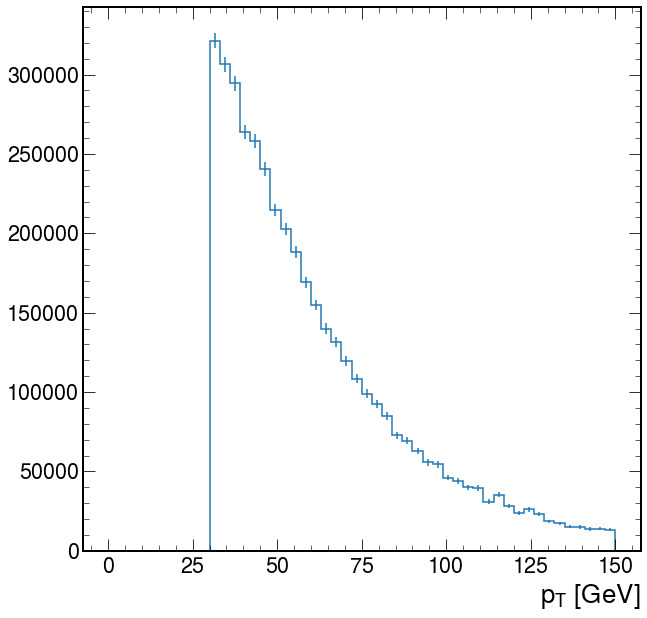

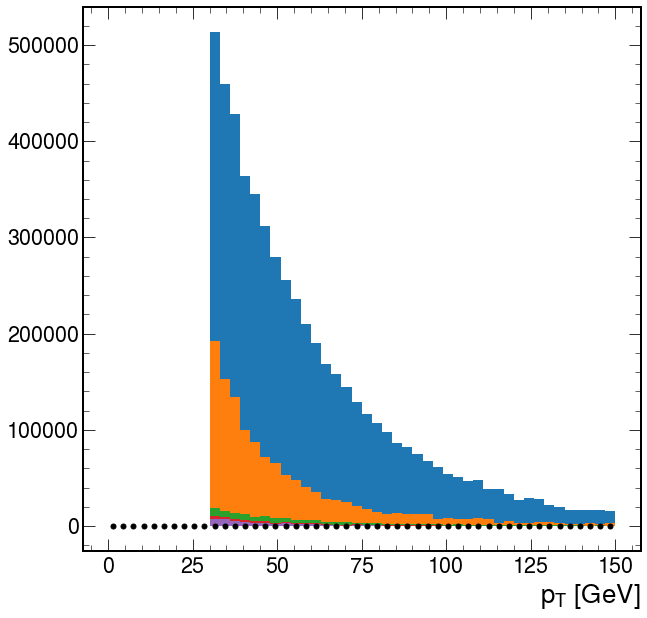

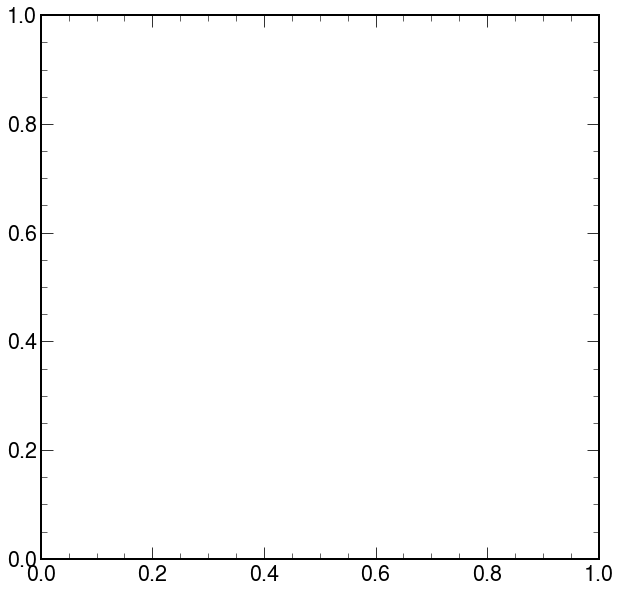

In [22]:
from coffea.util import load
import matplotlib.pyplot as plt
import mplhep as hep

# load coffea
output = load("output.coffea")
plt.style.use(hep.style.ROOT)

# get plot from
fig, ax = plt.subplots()
hep.histplot(
    output["TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8"]["muon_pt"], label="muon pT", ax=ax
)

# stack the MC and overlay data with errorbar
fig, ax2 = plt.subplots()
hep.histplot(
    [output[s]["muon_pt"] for s in output.keys() if "Run" not in s],
    histtype="fill",
    stack=True,
    label=[s for s in output.keys() if "Run" not in s],
    ax=ax2,
)
hep.histplot(
    [output[s]["muon_pt"] for s in output.keys() if "Run" in s],
    histtype="errorbar",
    label=[s for s in output.keys() if "Run" in s],
    ax=ax2,
    color="k",
)
plt.legend()

In [24]:
output["TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8"]["jet_pt"]

Hist(
  IntCategory([0, 1, 4, 5, 6], name='flav', label='Genflavour'),
  Regular(50, 0, 300, name='pt', label='$p_T$ [GeV]'),
  storage=Weight()) # Sum: WeightedSum(value=8.49974e+06, variance=6.2225e+08) (WeightedSum(value=8.61315e+06, variance=6.30622e+08) with flow)

You can have multidimesional slicing in the stored histogram, but plotting tools only allow 1D/2D representation. 
See more in [hist](https://hist.readthedocs.io/en/latest/user-guide/quickstart.html)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fa3615882b0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

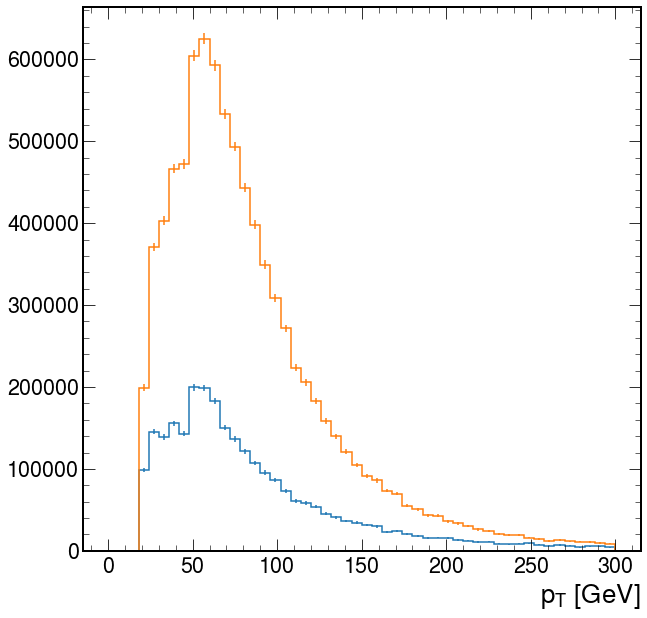

In [25]:
# specify the fisrt bin(light flavor)
hep.histplot(output["TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8"]["jet_pt"][{"flav": 0}])
# you can also sum over the flavor composition, collapse as 1D histogram like electron_pt
hep.histplot(output["TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8"]["jet_pt"][{"flav": sum}])